In [67]:





import datetime
import pytz
import pandas as pd
import MetaTrader5 as mt5
import matplotlib.pyplot as plt
import numpy as np
import pandas_ta as ta






In [68]:





# 30 min time frame
frameM30 = mt5.TIMEFRAME_M30

#1 min time frame
frameM1 = mt5.TIMEFRAME_M1

# 1 hour time frame
frameH1 = mt5.TIMEFRAME_H1





In [69]:





def getAssetList(assetSet = None):
    assetList = []
    if assetSet == 1:
        assetList = ['EURUSD', 'USDCHF']
    return assetList

        





In [70]:







## Defining the getQuotes method

def getQuotes(mt5TimeFrame, year = 2020, month = 1, day = 1, asset ='EURUSD'):
    
    ## Establishing the connection to MetaTrader 5
    if not mt5.initialize():
        print(f'MT5 initialization failed: Error code = {mt5.last_error}')
        quit()

    # Current time
    currentTime = datetime.datetime.now()

    # Defining the timezone and created utcFrom and utcTo dates
    timeZone = pytz.timezone('Asia/Kolkata')
    utcFrom = datetime.datetime(year, month, day, tzinfo = timeZone)
    utcTo = datetime.datetime(currentTime.year, currentTime.month, currentTime.day, tzinfo = timeZone)
    
    # Retrieving the data and returning it after converting it to pd dataframe
    return pd.DataFrame(mt5.copy_rates_range(asset, mt5TimeFrame, utcFrom, utcTo))







In [71]:



df = getQuotes(frameM30, 2023, 1, 1)
df





,time,open,high,low,close,tick_volume,spread,real_volume
0,1672617600,1.06959,1.07017,1.06936,1.06937,71,54,0
1,1672619400,1.06936,1.06965,1.06883,1.06892,2833,71,0
2,1672621200,1.06892,1.06978,1.06873,1.06968,212,54,0
3,1672623000,1.06968,1.07021,1.06957,1.07021,208,54,0
4,1672624800,1.07012,1.07052,1.06953,1.06965,220,22,0
...,...,...,...,...,...,...,...,...
9056,1695312000,1.06416,1.06538,1.06384,1.06532,5855,9,0
9057,1695313800,1.06532,1.06609,1.06389,1.06402,7385,9,0
9058,1695315600,1.06402,1.06651,1.06374,1.06618,7014,9,0
9059,1695317400,1.06618,1.06731,1.06570,1.06595,5224,9,0


In [72]:



def psar(df = None, af0=0.02, af=0.02, maxaf=0.2, offset=0):
    psar = ta.psar(high=df['high'], low=df['low'], close=df['close'], af0=af0, af=af,max_af=maxaf, offset=0)
    df[f'PSARl_{af}_{maxaf}'] = psar[f'PSARl_{af}_{maxaf}']
    df[f'PSARs_{af}_{maxaf}'] = psar[f'PSARs_{af}_{maxaf}']
    df[f'PSARaf_{af}_{maxaf}'] = psar[f'PSARaf_{af}_{maxaf}']
    df[f'PSARr_{af}_{maxaf}'] = psar[f'PSARr_{af}_{maxaf}']
    return df




In [73]:


af0=0.02
af=0.02
maxaf=0.2
offset=0

df = psar(df, af0, af, maxaf, offset)

df



,time,open,high,low,close,tick_volume,spread,real_volume,PSARl_0.02_0.2,PSARs_0.02_0.2,PSARaf_0.02_0.2,PSARr_0.02_0.2
0,1672617600,1.06959,1.07017,1.06936,1.06937,71,54,0,NaN,NaN,0.02,0
1,1672619400,1.06936,1.06965,1.06883,1.06892,2833,71,0,1.068830,NaN,0.02,1
2,1672621200,1.06892,1.06978,1.06873,1.06968,212,54,0,NaN,1.069780,0.02,1
3,1672623000,1.06968,1.07021,1.06957,1.07021,208,54,0,1.068730,NaN,0.02,1
4,1672624800,1.07012,1.07052,1.06953,1.06965,220,22,0,1.068730,NaN,0.04,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9056,1695312000,1.06416,1.06538,1.06384,1.06532,5855,9,0,NaN,1.065471,0.10,0
9057,1695313800,1.06532,1.06609,1.06389,1.06402,7385,9,0,1.062370,NaN,0.02,1
9058,1695315600,1.06402,1.06651,1.06374,1.06618,7014,9,0,1.062444,NaN,0.04,0
9059,1695317400,1.06618,1.06731,1.06570,1.06595,5224,9,0,1.062607,NaN,0.06,0


In [74]:

openPosition = None
targetPrice = None
buys = []
sells = []

buysIndices = []
sellsIndices = []
pctRise = 0.01

for i in range(len(df)):
    if (i > 0) and (openPosition is None) and (df.iloc[i][f'PSARl_{af}_{maxaf}'] > 0):
        openPosition = 'long'
        buys.append(df.iloc[i]['close'])
        buysIndices.append(i)
        targetPrice = df.iloc[i]['close'] + (pctRise * df.iloc[i]['close'])
    elif (i > 0) and (openPosition) and (df.iloc[i][f'PSARs_{af}_{maxaf}'] > 0) and (df.iloc[i]['close'] >= targetPrice):
        openPosition = None
        sells.append(df.iloc[i]['close'])
        sellsIndices.append(i)
        targetPrice = None




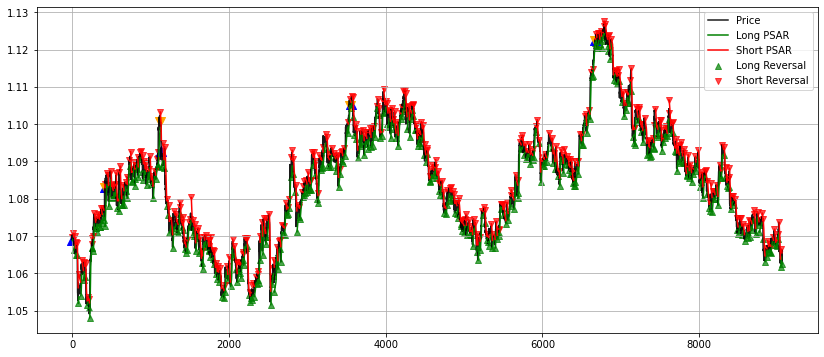

In [75]:




plt.figure(figsize=(14, 6))

plt.plot(df['close'], label='Price', color='black', alpha=0.9)
plt.plot(df.index, df[f'PSARl_{af}_{maxaf}'], label='Long PSAR', color='green')
plt.plot(df.index, df[f'PSARs_{af}_{maxaf}'], label='Short PSAR', color='red')

# Reversal Signals
reversalPts = df[df[f'PSARr_{af}_{maxaf}'] != 0]
plt.scatter(reversalPts.index, reversalPts[f'PSARl_{af}_{maxaf}'], marker='^', color='green', label='Long Reversal', alpha=0.7)
plt.scatter(reversalPts.index, reversalPts[f'PSARs_{af}_{maxaf}'], marker='v', color='red', label='Short Reversal', alpha=0.7)


# Scattering the buy, sell indices
plt.scatter(df.iloc[buysIndices].index, df.iloc[buysIndices]['close'], marker = '^', color = 'blue', s = 100)
plt.scatter(df.iloc[sellsIndices].index, df.iloc[sellsIndices]['close'], marker = 'v', color = 'orange', s = 100)


plt.legend()
plt.grid(True)
plt.show()




In [76]:








# P & L and other details

totalPL = 0
winTrades = 0
loseTrades = 0
maximumWin = None
maximumLose = None
maximumPercentageWin = None
maximumPercentageLoss = None

for i in range(len(sells)):
    netResult = sells[i] - buys[i]
    maximumValue = max(sells[i], buys[i])
    netResult = netResult - (0.002 * maximumValue);
    percentageWinOrLoss = (netResult / maximumValue) * 100
    message = None

    if netResult < 0:
        loseTrades += 1
        message = f'Lost {percentageWinOrLoss}'
    else:
        winTrades += 1
        message = f'Win {percentageWinOrLoss}'

    if not maximumWin or netResult > maximumWin:
        maximumWin = netResult

    if not maximumLose or netResult < maximumLose:
        maximumLose = netResult

    if not maximumPercentageWin or percentageWinOrLoss > maximumPercentageWin:
        maximumPercentageWin = percentageWinOrLoss

    if not maximumPercentageLoss or percentageWinOrLoss < maximumPercentageLoss:
        maximumPercentageLoss = percentageWinOrLoss

    totalPL = totalPL + netResult
    print(message)

print(f'Total P & L = {totalPL}')
print(f'Win Trades = {winTrades}')
print(f'Lose Trades = {loseTrades}')
print(f'Maximum Win = {maximumWin}')
print(f'Maximum Lose = {maximumLose}')
print(f'Maximum Percentage Win = {maximumPercentageWin}')
print(f'MaximumPercentage Loss = {maximumPercentageLoss}')






Win 1.0773031632417462
Win 1.3720984333539394
Win 0.8969914195720765
Win 1.2961682409552735
Total P & L = 0.05121954000000031
Win Trades = 4
Lose Trades = 0
Maximum Win = 0.015099120000000093
Maximum Lose = 0.00991032000000013
Maximum Percentage Win = 1.3720984333539394
MaximumPercentage Loss = 0.8969914195720765
